# Custom 2 Layered Neural Network Model

In [ ]:
# import the required libraries
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets for .25%, 1%, 3% and 5% sparsities:

In [ ]:
# NOTE: Use your file paths for each of them:
df_train_25 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_train_final_.25_.csv')
df_val_25 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_val_final_.25_.csv')
df_test_25 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_test_final_.25_.csv')
df_train_1 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_train_final_1_.csv')
df_val_1 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_val_final_1_.csv')
df_test_1 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_test_final_1_.csv')
df_train_3 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_train_final_3_.csv')
df_val_3 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_val_final_3_.csv')
df_test_3 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_test_final_3_.csv')
df_train_5 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_train_final_5_.csv')
df_val_5 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_val_final_5_.csv')
df_test_5 = pd.read_csv('/content/drive/MyDrive/meta_generated_data/RRAVIPRA_test_final_5_.csv')

In [ ]:
# Load your datasets for the particular sparsity level that you are training the model on
X_train = df_train_5['message']
y_train = df_train_5['label']
X_val = df_val_5['message']
y_val = df_val_5['label']
X_test = df_test_5['message']
y_test = df_test_5['label']

# Encode text data into numerical form
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_val_vec = vectorizer.transform(X_val).toarray()

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_vec)
y_train_tensor = torch.LongTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val_vec)
y_val_tensor = torch.LongTensor(y_val.values)

# Handling imbalance - calculate weights for each class
class_counts = y_train.value_counts().to_dict()
class_weights = {class_id: 1.0/count for class_id, count in class_counts.items()}
weights = [class_weights[class_id] for class_id in y_train]

sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))

# Build the model:

In [ ]:
# Define the model
class TextClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Create the dataset and the data loader:

In [ ]:
# Create Dataset and DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, sampler=sampler)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)

# Model parameters, loss and optimizer:

In [ ]:
# Model parameters
input_dim = X_train_vec.shape[1]
hidden_dim = 128
output_dim = 1

# Initialize model, loss, and optimizer
model = TextClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5

epoch_metrics = []  # Initialize list to store metrics for each epoch

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    y_val_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_losses.append(loss.item())
            y_val_pred.extend(outputs.squeeze().tolist())

    y_val_pred_bin = [1 if y > 0.5 else 0 for y in y_val_pred]
    accuracy = accuracy_score(y_val, y_val_pred_bin)
    auc_roc = roc_auc_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred_bin)
    precision = precision_score(y_val, y_val_pred_bin)
    recall = recall_score(y_val, y_val_pred_bin)

    # Append metrics for the current epoch to the list
    epoch_metrics.append({
        'Epoch': epoch + 1,
        'Train Loss': sum(train_losses) / len(train_losses),
        'Validation Loss': sum(val_losses) / len(val_losses),
        'Accuracy': accuracy,
        'AUC-ROC': auc_roc,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall
    })

# Create a DataFrame from the metrics list after all epochs
metrics_df = pd.DataFrame(epoch_metrics)

# Display the DataFrame
metrics_df

,Epoch,Train Loss,Validation Loss,Accuracy,AUC-ROC,F1 Score,Precision,Recall
0,1,0.222956,0.192359,0.927226,0.797376,0.022104,0.011444,0.322581
1,2,0.175251,0.161316,0.942031,0.817748,0.025981,0.013572,0.303226
2,3,0.124705,0.133139,0.950404,0.828819,0.035817,0.018843,0.361290
3,4,0.082166,0.100140,0.963580,0.833145,0.045690,0.024480,0.341935
4,5,0.054536,0.082216,0.971279,0.832704,0.056216,0.030678,0.335484


# AUC/ROC Curves:

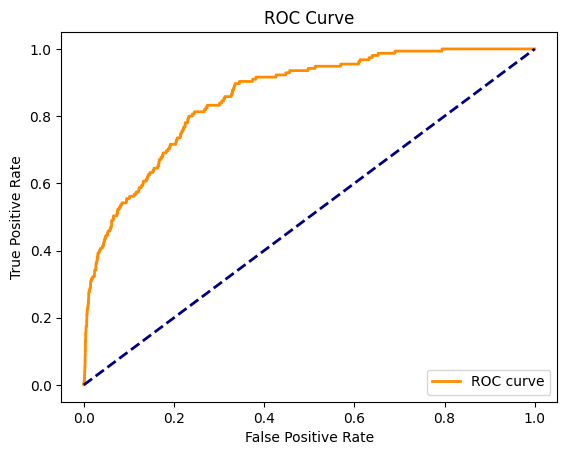

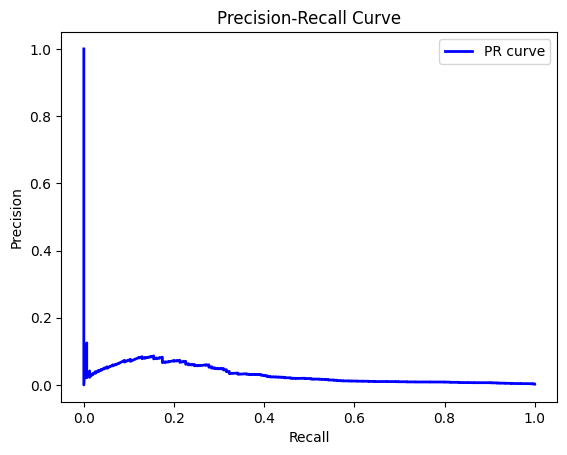

,Metric,Value
0,Accuracy,0.972512
1,AUC-ROC,0.858409
2,F1 Score,0.059651
3,Precision,0.032676
4,Recall,0.341935


In [ ]:
# Compute predictions on the test set
X_test_vec = vectorizer.transform(X_test).toarray()
X_test_tensor = torch.FloatTensor(X_test_vec)
y_test_tensor = torch.LongTensor(y_test.values)

model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).squeeze().tolist()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_tensor, y_test_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Plot PR curve
precision, recall, _ = precision_recall_curve(y_test_tensor, y_test_pred)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

# Evaluate on the test set
y_test_pred_bin = [1 if y > 0.5 else 0 for y in y_test_pred]
accuracy_test = accuracy_score(y_test_tensor, y_test_pred_bin)
auc_roc_test = roc_auc_score(y_test_tensor, y_test_pred)
f1_test = f1_score(y_test_tensor, y_test_pred_bin)
precision_test = precision_score(y_test_tensor, y_test_pred_bin)
recall_test = recall_score(y_test_tensor, y_test_pred_bin)
conf_matrix_test = confusion_matrix(y_test_tensor, y_test_pred_bin)

test_evaluation_df = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC-ROC', 'F1 Score', 'Precision', 'Recall'],
    'Value': [accuracy_test, auc_roc_test, f1_test, precision_test, recall_test]
})

test_evaluation_df

# Confusion Matrix:

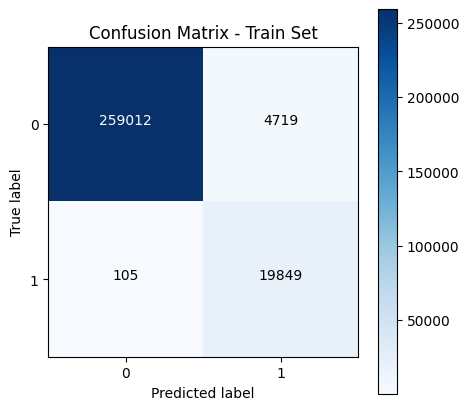

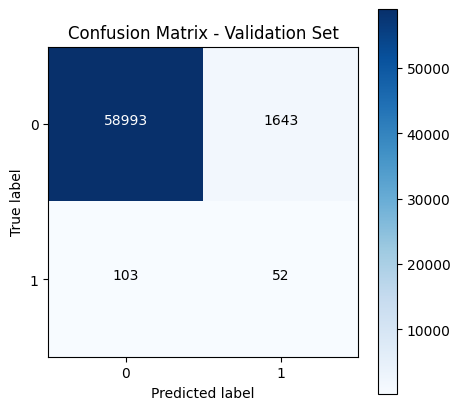

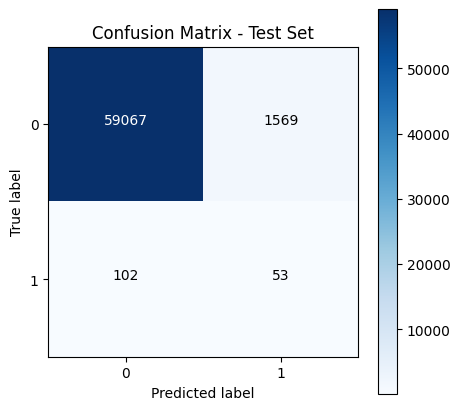

In [ ]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    plt.show()

conf_matrix_train = confusion_matrix(y_train_tensor, [1 if y > 0.5 else 0 for y in model(X_train_tensor).squeeze().tolist()])
plot_confusion_matrix(conf_matrix_train, "Confusion Matrix - Train Set")

conf_matrix_val = confusion_matrix(y_val_tensor, [1 if y > 0.5 else 0 for y in model(X_val_tensor).squeeze().tolist()])
plot_confusion_matrix(conf_matrix_val, "Confusion Matrix - Validation Set")

plot_confusion_matrix(conf_matrix_test, "Confusion Matrix - Test Set")